In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
print("Librerias cargadas correctamente")

Librerias cargadas correctamente


### Iniciamos la exploracion de los datos

In [64]:
# Cargar los datos desde un archivo CSV
dataframe = pd.read_csv('supermarket_es.csv')
print("Datos cargados correctamente")

# Mostrar las primeras filas del DataFrame
dataframe.head()

Datos cargados correctamente


,Transaction,Item,date_time,period_day,weekday_weekend,producto
0,1,Bread,30-10-2016 09:58,morning,weekend,Pan
1,2,Scandinavian,30-10-2016 10:05,morning,weekend,Pan escandinavo
2,2,Scandinavian,30-10-2016 10:05,morning,weekend,Pan escandinavo
3,3,Hot chocolate,30-10-2016 10:07,morning,weekend,Chocolate caliente
4,3,Jam,30-10-2016 10:07,morning,weekend,Mermelada


In [65]:
# Revisamos el tipo de dato de cada columna. 
# Este paso es fundamental para asegurar que los datos se procesen correctamente.
print("<<<< Detalles sobre tipos de datos >>>>\n") 
print(dataframe.info())
print("\n--Existen valores nulos por columna?")
print(dataframe.isnull().sum())

<<<< Detalles sobre tipos de datos >>>>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20507 entries, 0 to 20506
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Transaction      20507 non-null  int64 
 1   Item             20507 non-null  object
 2   date_time        20507 non-null  object
 3   period_day       20507 non-null  object
 4   weekday_weekend  20507 non-null  object
 5   producto         20507 non-null  object
dtypes: int64(1), object(5)
memory usage: 961.4+ KB
None

--Existen valores nulos por columna?
Transaction        0
Item               0
date_time          0
period_day         0
weekday_weekend    0
producto           0
dtype: int64


#### Observaciones
- Podemos ver que los datos están bien asociados y que no encontramos valores nulos o faltantes.
- Hemos traducido el nombre original a español en la columna "Producto".

#### Avanzamos a la preparación de los datos.

In [66]:
# Guardamos una copia del dataframe original para futuras referencias
df = dataframe.copy()

# Quitamos la columna duplicada y nos quedamos con las que nos interesan
df = df.drop(columns=['date_time' ,'Item'])

# Mostrar las primeras filas del DataFrame
df.head()

,Transaction,period_day,weekday_weekend,producto
0,1,morning,weekend,Pan
1,2,morning,weekend,Pan escandinavo
2,2,morning,weekend,Pan escandinavo
3,3,morning,weekend,Chocolate caliente
4,3,morning,weekend,Mermelada


En este punto debemos tener en cuenta que 'Trasaction' tiene repetidos los numeros, lo que indica que hay varios productos que pertenecen a la misma compra. Para poder analizarlos correctamente es necesario luego unirlos para que compongan una canasta de compras.

In [67]:
# Profundicemos un poco más en los datos para entender su estructura y contenido.
print("\n<<<< Valores únicos por columna >>>>\n")
print(df.nunique())


<<<< Valores únicos por columna >>>>

Transaction        9465
period_day            4
weekday_weekend       2
producto             94
dtype: int64


In [73]:
# procedemos a unir los datos que forman parte de la mismca transacción
basket = df.groupby(['Transaction', 'period_day', 'weekday_weekend'])[['producto']].agg(lambda x: ', '.join(x.astype(str))).reset_index()
basket.head(20)

,Transaction,period_day,weekday_weekend,producto
0,1,morning,weekend,Pan
1,2,morning,weekend,"Pan escandinavo, Pan escandinavo"
2,3,morning,weekend,"Chocolate caliente, Mermelada, Galletas"
3,4,morning,weekend,Muffin
4,5,morning,weekend,"Cafe, Pastelito, Pan"
5,6,morning,weekend,"Medialuna, Pastelito, Muffin"
6,7,morning,weekend,"Medialuna, Pastelito, Cafe, Te"
7,8,morning,weekend,"Pastelito, Pan"
8,9,morning,weekend,"Pan, Muffin"
9,10,morning,weekend,"Pan escandinavo, Medialuna"


In [81]:
# Convertir los datos al formato adecuado para el análisis de reglas de asociación

# Primero, separar los productos y crear columnas binarias
mlb = MultiLabelBinarizer()

# Convertir la cadena de productos en lista
basket['productos_lista'] = basket['producto'].str.split(', ')

# Aplicar one-hot encoding
basket_encoded = pd.DataFrame(
    mlb.fit_transform(basket['productos_lista']),
    columns=mlb.classes_,
    index=basket.index
)

# Convertir a tipo booleano
basket_encoded = basket_encoded.astype(bool)

# Agregar las columnas de contexto si las necesitas
basket_encoded = pd.concat([basket[['Transaction', 'period_day', 'weekday_weekend']], basket_encoded], axis=1)

print(f"Dimensiones: {basket_encoded.shape}")
basket_encoded.head(20)

Dimensiones: (9465, 97)


,Transaction,period_day,weekday_weekend,Aceite con chimichurri,Agua mineral,Ajuste,Alfajores,Baguette,Bandeja artistica,Banquete vegano,...,Tarta Bakewell,Te,Tiffin,Tocino,Torre de pancakes,Tostada,Tostada tartine,Trufas,Untable,Vale de regalo
0,1,morning,weekend,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,morning,weekend,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,morning,weekend,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,4,morning,weekend,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,5,morning,weekend,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,6,morning,weekend,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,7,morning,weekend,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
7,8,morning,weekend,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,9,morning,weekend,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,10,morning,weekend,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [86]:
# Iniciamos el análisis de reglas de asociación
frequent_itemsets = apriori(basket_encoded.drop(columns=['Transaction', 'period_day', 'weekday_weekend']), min_support=0.015, use_colnames=True)
print(f"Frequent itemsets encontrados: {len(frequent_itemsets)}")
frequent_itemsets.head()

# Generar las reglas de asociación
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
print(f"Reglas generadas: {len(rules)}")
rules.head()

# Filtrar reglas con lift mayor a 1.2 para obtener las más relevantes
strong_rules = rules[rules['lift'] > 1.1]
print(f"Reglas fuertes (lift > 1.2): {len(strong_rules)}")
strong_rules.head()

# Crear una tabla con las reglas fuertes
strong_rules_table = strong_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
print("Tabla de reglas fuertes:")
strong_rules_table

Frequent itemsets encontrados: 46
Reglas generadas: 28
Reglas fuertes (lift > 1.2): 16
Tabla de reglas fuertes:


,antecedents,consequents,support,confidence,lift
0,(Cafe),(Alfajores),0.019651,0.041078,1.130235
1,(Alfajores),(Cafe),0.019651,0.540698,1.130235
8,(Cafe),(Jugo),0.020602,0.043065,1.116750
9,(Jugo),(Cafe),0.020602,0.534247,1.116750
10,(Cafe),(Medialuna),0.035182,0.073542,1.189878
11,(Medialuna),(Cafe),0.035182,0.569231,1.189878
14,(Cafe),(Pastel),0.054728,0.114399,1.101515
15,(Pastel),(Cafe),0.054728,0.526958,1.101515
16,(Cafe),(Pastelito),0.047544,0.099382,1.154168
17,(Pastelito),(Cafe),0.047544,0.552147,1.154168


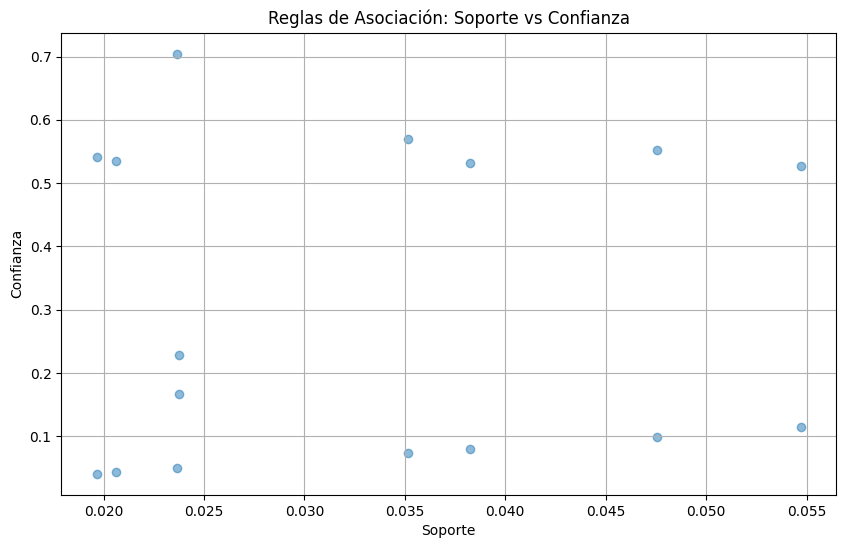

In [87]:
# Visualizar las reglas fuertes
plt.figure(figsize=(10, 6))
plt.scatter(strong_rules['support'], strong_rules['confidence'], alpha=0.5)
plt.title('Reglas de Asociación: Soporte vs Confianza')
plt.xlabel('Soporte')
plt.ylabel('Confianza')
plt.grid(True)
plt.show()
